In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from alpha_vantage.timeseries import TimeSeries
import requests
import json

In [3]:
def get_fx_data(instrument,periods,granularity,end=None):
    """Returns pandas dataframe of ohlc and volume data"""
    rest_url = "https://api-fxpractice.oanda.com/"
    stream_url = "https://stream-fxpractice.oanda.com/"
    access_token = "7504cc953a3efe6542a1b0181f7a69b0-f5e662a814de4b0d43ea9c206a8e44ce"
    account_id = "101-001-17749174-001"
    authorization_header = {'Authorization':f'Bearer {access_token}','Accept-Datetime-Format':'UNIX', 'Content-type':'application/json'}
    if not end:
        end_point = f"v3/instruments/{instrument}/candles?granularity={granularity}&count={periods}"
    else:
        end_point = f"v3/instruments/{instrument}/candles?granularity={granularity}&count={periods}&to={str(end)}"
    r = requests.get(rest_url+end_point, headers=authorization_header)
    if "errorMessage" in json.loads(r.text).keys():
        print('Error retrieving data')
    else:
        dic = json.loads(r.content)
        candles = dic['candles']
        df = pd.DataFrame()
        df['Open'] = [float(candle['mid']['o']) for candle in candles]
        df['High'] = [float(candle['mid']['h']) for candle in candles]
        df['Low'] = [float(candle['mid']['l']) for candle in candles]
        df['Close'] = [float(candle['mid']['c']) for candle in candles]
        df['Volume'] = [float(candle['volume']) for candle in candles]
        df.index = [dt.datetime.fromtimestamp(float(candle['time'])) for candle in candles]
        return df

In [4]:
#Add indicators to data
def EMA(df,n):
    df[f'EMA {n}'] = df['Close'].ewm(n,min_periods=n).mean()

def fractals(df):
    bear_fractals = [np.nan]*len(df)
    bull_fractals = [np.nan]*len(df)
    for i in range(2,len(df)-2):
        high = df['High'][i]
        low = df['Low'][i]

        if high > df['High'][i-1] and high > df['High'][i-2] and high > df['High'][i+1] and high > df['High'][i+2]:
            bear_fractals[i] = df['High'][i]
        if low < df['Low'][i-1] and low < df['Low'][i-2] and low < df['Low'][i+1] and low < df['Low'][i+2]:
            bull_fractals[i] = df['Low'][i]
    df['bull_fractals'] = bull_fractals
    df['bear_fractals'] = bear_fractals

Strategy: EMA and fractal scalping strategy
- 20,50, and 100 ema
- williams fractal
- Ema's must be in order (20>50>100 or 20<50<100)
- wait for pull back into 20 or 50 ema
- Once pulled back wait for direction fractal
- Place stop loss at 50 if pulled into 20 or 100 if pulled into 50
- 1.5 risk/reward
- Price cannot close below 100 ema

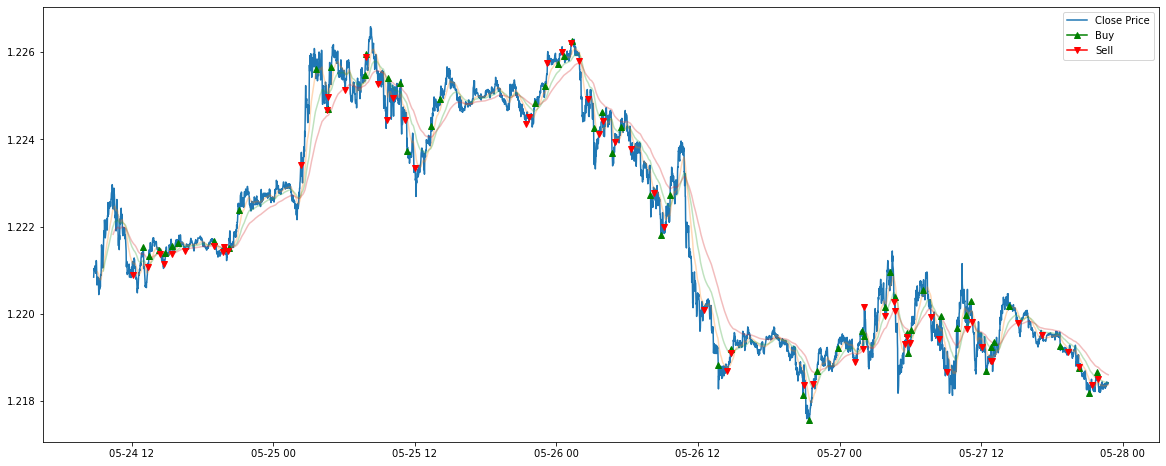

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


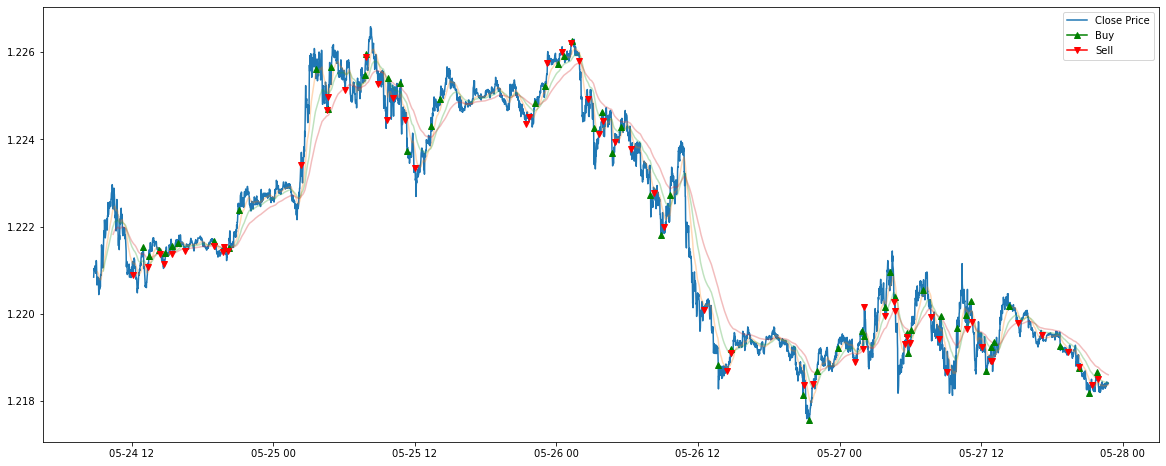

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


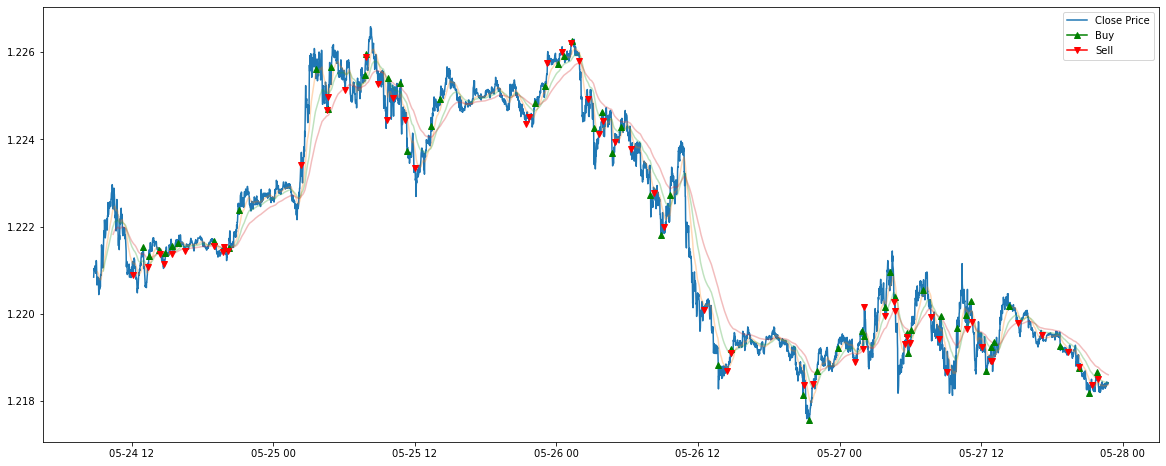

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


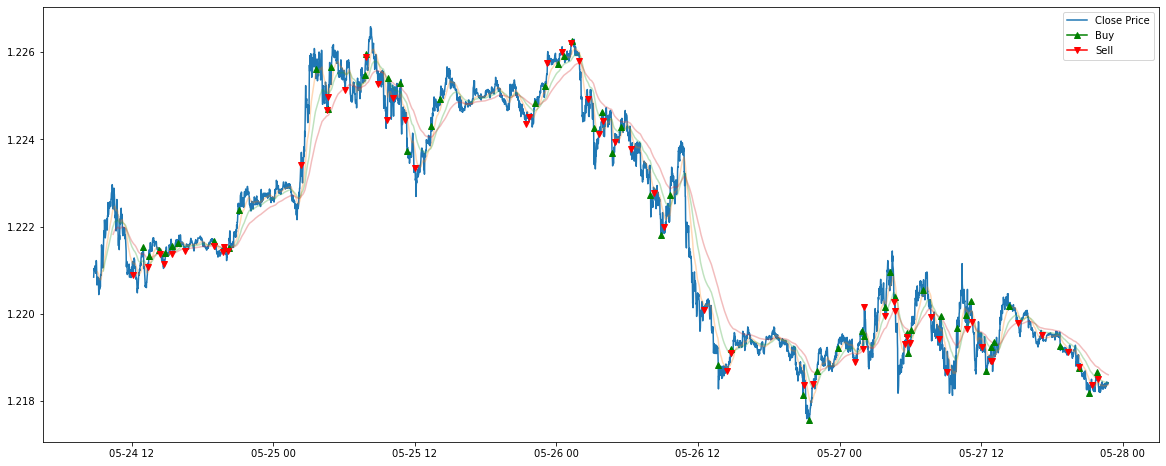

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


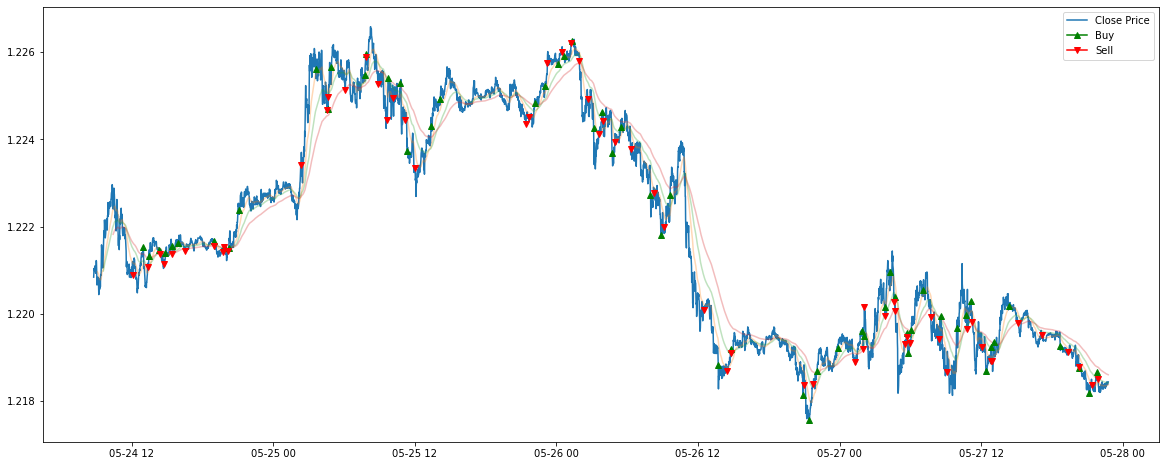

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


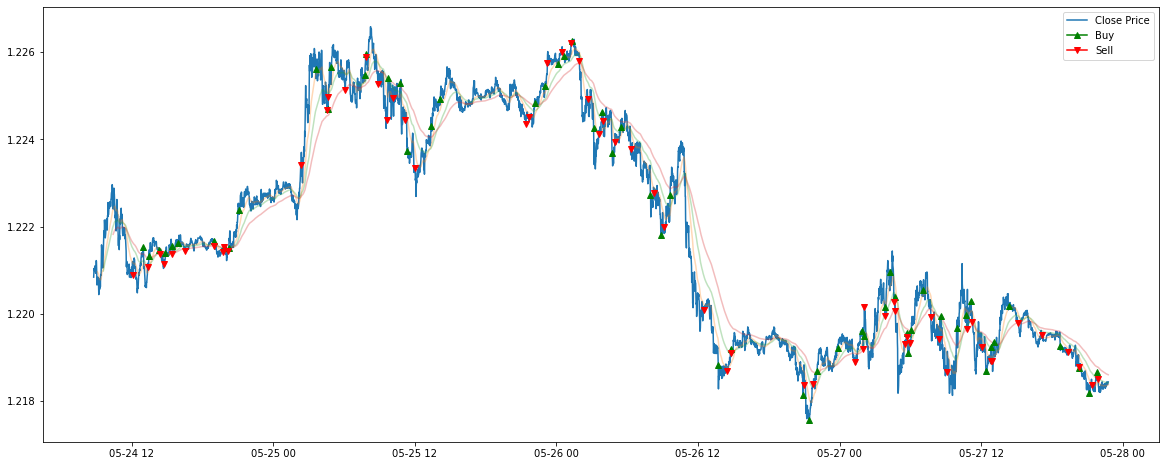

Winners: 21
Losers: 39
Total trades: 60
Winning percentage: 35.0%
Winners in a row: 3
Losers in a row: 8
Gain on account: -7.5%
Span of trades: 3 days 13:59:00


KeyboardInterrupt: 

In [5]:
def backtest(df):
    pos = None #Position
    buy = [np.nan]*len(df) #Used for plotting buy signals
    sell = [np.nan]*len(df) #Used for plotting sell signals
    winners = 0 #Total winning trades
    losers = 0 #Total losing trades
    consec_wins = 0 #Current consecutive wins
    consec_losses = 0 #Current consecutive wins
    max_wins = 0 #Most wins in a row
    max_losses = 0 #Most losses in a row
    
    #Variables for strategy
    pullback20 = False
    pullback50 = False
    profit_loss_ratio = 1.5
    for i in range(2,len(df)):
        c = df['Close'][i]
        ema20 = df['EMA 20'][i]
        ema50 = df['EMA 50'][i]
        ema100 = df['EMA 100'][i]
        bull_fractal = not np.isnan(df['bull_fractals'][i-2])
        bear_fractal = not np.isnan(df['bear_fractals'][i-2])

        if ema20 > ema50 and ema50 > ema100 and not pos:
            above20 = False
            pullback20 = False
            pullback50 = False
            pullback100 = False
            for di in range(15):
                if df['Close'][i-15+di] > ema20:
                    above20 = True
                if above20 and df['Close'][i-15+di] < ema20:
                    pullback20 = True
                if above20 and df['Close'][i-15+di] < ema50:
                    pullback50 = True
                if df['Close'][i-15+di] < ema100:
                    pullback100 = True

            if (pullback20 or pullback50) and not pullback100 and bull_fractal:
                stop = ema100 if pullback50 else ema50
                pos = {'typ':"LONG",'buy_price':c,'stop_loss':stop,'take_profit':c + profit_loss_ratio*(c-stop)}
                buy[i] = c
        if ema20 < ema50 and ema50 < ema100 and not pos:
            below20 = False
            pullback20 = False
            pullback50 = False
            pullback100 = False
            for di in range(15):
                if df['Close'][i-15+di] < ema20:
                    below20 = True
                if below20 and df['Close'][i-15+di] > ema20:
                    pullback20 = True
                if below20 and df['Close'][i-15+di] > ema50:
                    pullback50 = True
                if df['Close'][i-15+di] > ema100:
                    pullback100 = True

            if (pullback20 or pullback50) and not pullback100 and bear_fractal:
                stop = ema100 if pullback50 else ema50
                pos = {'typ':"SHORT",'buy_price':c,'stop_loss':stop,'take_profit':c - profit_loss_ratio*(stop-c)}
                sell[i] = c
        
        elif pos:
            if pos['typ'] == 'LONG':
                if c >= pos['take_profit']:
                    winners += 1
                    consec_wins += 1
                    consec_losses = 0
                    if consec_wins > max_wins:
                        max_wins = consec_wins
                    pos = None
                    sell[i] = c
                elif c <= pos['stop_loss']:
                    losers += 1
                    consec_losses += 1
                    consec_wins = 0
                    if consec_losses > max_losses:
                        max_losses = consec_losses
                    pos = None
                    sell[i] = c
            elif pos['typ'] == 'SHORT':
                if c <= pos['take_profit']:
                    winners += 1
                    consec_wins += 1
                    consec_losses = 0
                    if consec_wins > max_wins:
                        max_wins = consec_wins
                    pos = None
                    buy[i] = c
                elif c >= pos['stop_loss']:
                    losers += 1
                    consec_losses += 1
                    consec_wins = 0
                    if consec_losses > max_losses:
                        max_losses = consec_losses
                    pos = None
                    buy[i] = c
    
    plt.figure(figsize=(20,8))
    plt.plot(df['Close'],label='Close Price')
    plt.plot(df['EMA 20'],alpha=0.3)
    plt.plot(df['EMA 50'],alpha=0.3)
    plt.plot(df['EMA 100'],alpha=0.3)
    plt.plot(df.index,buy,marker='^',color='green',label='Buy')
    plt.plot(df.index,sell,marker='v',color='red',label='Sell')
    plt.legend()
    plt.show()
    print(f'Winners: {winners}')
    print(f'Losers: {losers}')
    print(f'Total trades: {winners + losers}')
    print(f'Winning percentage: {100*round(winners/(winners+losers),2) if winners+losers > 0 else 0}%')
    print(f'Winners in a row: {max_wins}')
    print(f'Losers in a row: {max_losses}')
    print(f'Gain on account: {winners*profit_loss_ratio - losers}%')
    print(f'Span of trades: {df.index[-1]-df.index[0]}')

symbols = ['EUR_USD','USD_JPY','GBP_USD','EUR_GBP','USD_CHF']
for s in symbols:
    for i in range(10):
        data = get_fx_data(s,5000,"M1",dt.datetime.today()-dt.timedelta(days=i*1))
        data = get_fx_data(s,5000,'M1')
        EMA(data,20)
        EMA(data,50)
        EMA(data,100)
        fractals(data)
        backtest(data)

In [19]:
test = get_fx_data("EUR_USD",5000,"M1",)
EMA(test,50)
EMA(test,100)
test.dropna(axis=0,inplace=True)
test

,Open,High,Low,Close,Volume,EMA 50,EMA 100
2021-05-24 10:39:00,1.22219,1.22220,1.22206,1.22208,151.0,1.222163,1.222007
2021-05-24 10:40:00,1.22208,1.22214,1.22186,1.22194,132.0,1.222158,1.222006
2021-05-24 10:41:00,1.22192,1.22196,1.22178,1.22190,120.0,1.222152,1.222004
2021-05-24 10:42:00,1.22190,1.22228,1.22190,1.22224,107.0,1.222154,1.222008
2021-05-24 10:43:00,1.22226,1.22242,1.22223,1.22242,102.0,1.222160,1.222014
...,...,...,...,...,...,...,...
2021-05-27 22:55:00,1.21824,1.21830,1.21822,1.21822,23.0,1.218398,1.218576
2021-05-27 22:56:00,1.21824,1.21829,1.21824,1.21825,18.0,1.218395,1.218572
2021-05-27 22:57:00,1.21828,1.21841,1.21828,1.21841,69.0,1.218395,1.218571
2021-05-27 22:58:00,1.21840,1.21858,1.21838,1.21855,70.0,1.218398,1.218571


In [20]:
def ema_cross(df,short,long):
    """
    Modifies the dataframe [df] to have columns "bull_cross" and "bear_cross"
    indicating the cross of two different period emas
    
    df : pandas dataframe
    short : integer (short ema)
    long : integer (long ema)
    
    Note: assume df have columns "EMA {short}" and "EMA {long}"
    """
    bull_cross = [np.nan]*len(df)
    bear_cross = [np.nan]*len(df)
    for i in range(1,len(df)):
        prev_short = df[f'EMA {short}'][i-1]
        prev_long = df[f'EMA {long}'][i-1]
        cur_short = df[f'EMA {short}'][i]
        cur_long = df[f'EMA {long}'][i]
        
        if prev_short >= prev_long and cur_short <= cur_long:
            bear_cross[i] = df['Close'][i]
        elif prev_short <= prev_long and cur_short >= cur_long:
            bull_cross[i] = df['Close'][i]
    
    df['bull_cross'] = bull_cross
    df['bear_cross'] = bear_cross

ema_cross(test,50,100)
test

,Open,High,Low,Close,Volume,EMA 50,EMA 100,bull_cross,bear_cross
2021-05-24 10:39:00,1.22219,1.22220,1.22206,1.22208,151.0,1.222163,1.222007,NaN,NaN
2021-05-24 10:40:00,1.22208,1.22214,1.22186,1.22194,132.0,1.222158,1.222006,NaN,NaN
2021-05-24 10:41:00,1.22192,1.22196,1.22178,1.22190,120.0,1.222152,1.222004,NaN,NaN
2021-05-24 10:42:00,1.22190,1.22228,1.22190,1.22224,107.0,1.222154,1.222008,NaN,NaN
2021-05-24 10:43:00,1.22226,1.22242,1.22223,1.22242,102.0,1.222160,1.222014,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-27 22:55:00,1.21824,1.21830,1.21822,1.21822,23.0,1.218398,1.218576,NaN,NaN
2021-05-27 22:56:00,1.21824,1.21829,1.21824,1.21825,18.0,1.218395,1.218572,NaN,NaN
2021-05-27 22:57:00,1.21828,1.21841,1.21828,1.21841,69.0,1.218395,1.218571,NaN,NaN
2021-05-27 22:58:00,1.21840,1.21858,1.21838,1.21855,70.0,1.218398,1.218571,NaN,NaN


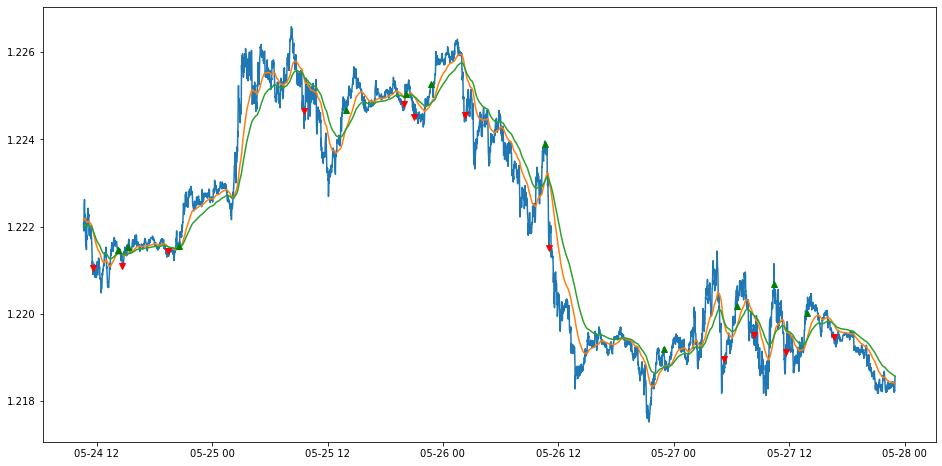

In [23]:
plt.figure(figsize=(16,8))
plt.plot(test['Close'])
plt.plot(test['EMA 50'])
plt.plot(test['EMA 100'])
plt.plot(test['bull_cross'],marker='^',color='g')
plt.plot(test['bear_cross'],marker='v',color='r')
plt.show()